In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
from PIL import Image

In [ ]:
# Define Parameters
NUM_CLASS = 5
IMG_SIZE = 224

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


In [ ]:
# download from google drive or upload file by yourself
!pip install --upgrade gdown
!gdown --fuzzy '1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7' --output retina-dataset.zip

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7
From (redirected): https://drive.google.com/uc?id=1jXEzNJr7iYJzhzl7695_0scTqJB0_5L7&confirm=t&uuid=2d71db75-bc35-4501-9662-3b26039231aa
To: /content/retina-dataset.zip
100% 622M/622M [00:25<00:00, 24.8MB/s]


In [ ]:
# unzip dataset file
!unzip -q retina-dataset.zip

#### Data Visualization

In [ ]:
df = pd.read_csv("kaggle_retina/train.csv")
df.head()

,id_code,diagnosis
0,c1e6fa1ad314,1
1,ed246ae1ed08,4
2,4d3de40ced3a,0
3,ae8472f8d310,1
4,3c28fd846b43,0


In [ ]:
paths = glob('kaggle_retina/train/*.png')
paths_test = sorted(glob('kaggle_retina/test/*.png'))
len(paths), len(paths_test)

(2197, 1465)

kaggle_retina/train/4dd7b322f342.png
label: 0


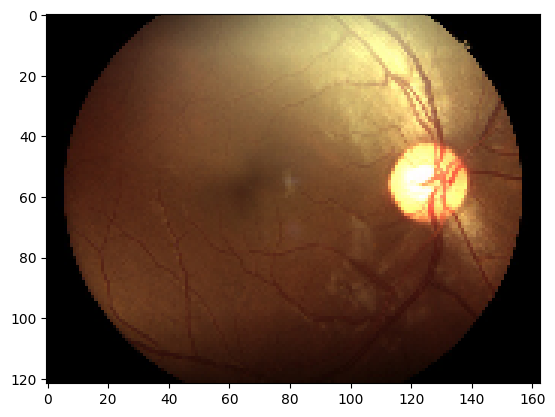

In [ ]:
idx = np.random.randint(0, len(df))
row = df.iloc[idx]
filename = row["id_code"]
path = f"kaggle_retina/train/{filename}.png"
img = cv2.imread(path)[:,:,::-1]
plt.imshow(img)
print(path)
print(f'label: {row["diagnosis"]}')

In [ ]:
all_cls = df['diagnosis'].tolist()
print(all_cls[:3])

[1, 4, 0]


<BarContainer object of 5 artists>

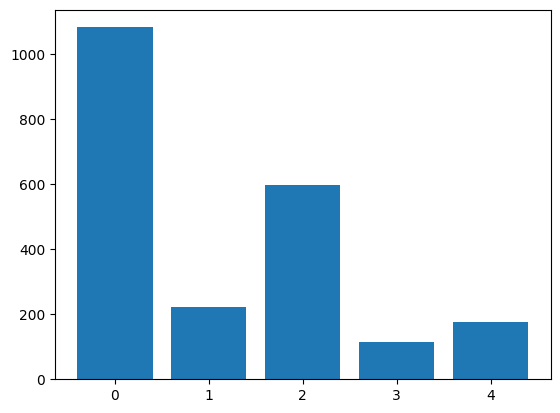

In [ ]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

#### [TODO] Dataset, DataLoader

Dataset & Data augumentation

#### Dataset & DataLoader


*   [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset)



*   Must implement

    1.   **\_\_len\_\_()**: size of dataset
    2.   **\_\_getitem\_\_()**: load a data sample for a given index

*   __getitem__() steps:
    1. Get image path
    2. Read image, resize
    3. Real image label
    4. convert image to tesnor and rescale to 0~1


ref: [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)


In [ ]:
import imgaug.augmenters as iaa
import imgaug as ia

In [ ]:
from torchvision import models, transforms
# from torchvision.models import googlenet, GoogLeNet_Weights
# from torchvision.models import densenet161, DenseNet161_Weights
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

In [ ]:
transform = ResNeXt50_32X4D_Weights.DEFAULT.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
class RetinaDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform, aug):
        self.df = df
        self.transform = transform
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Flipud(0.5), # 50% vertical flip
            iaa.Affine(
                rotate=(-10, 10), # random rotate -10 ~ +10 degree
                shear=(-16,16), # random shear -16 ~ +16 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])
        self.aug = aug


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["id_code"]
        path = f"kaggle_retina/train/{filename}.png"
        img = Image.open(path)
        img_np = np.array(img)
        if self.aug:
          img_np = self.seq.augment_image(img_np)
        img = Image.fromarray(img_np)

        img = self.transform(img)



        label = row["diagnosis"]
        label = torch.tensor(label, dtype=torch.long)

        return img, label

In [ ]:
# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, img_paths, df, Transform):
#         self.img_paths = img_paths
#         # self.img_size = img_size
#         self.df = df
#         self.transform = Transform

#         # self.seq = seq = iaa.Sequential([
#         #     iaa.Fliplr(0.5), # 50% horizontal flip
#         #     iaa.Flipud(0.5), # 50% vertical flip
#         #     iaa.Affine(
#         #         rotate=(-10, 10), # random rotate -10 ~ +10 degree
#         #         shear=(-16,16), # random shear -16 ~ +16 degree
#         #         scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
#         #     ),
#         # ])
#         # self.aug = aug
#     def __len__(self):
#         """number of samples"""
#         return len(self.img_paths)

#     def __getitem__(self, idx):
#         """read 1 sample"""
#         # Read img
#         row = df.iloc[idx]
#         filename = row["id_code"]
#         path = f"kaggle_retina/train/{filename}.png" # get img path
#         img = cv2.imread(path) # read img
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
#         # img = cv2.resize(img, (self.img_size, self.img_size)) # Resize iamge
#         # if self.aug:
#         #     img = self.seq.augment_image(img)
#         img = img / 255. # 0~255 -> 0.~1.
#         img = self.transform(img)
#         # Read class index
#         cls_idx = row['diagnosis']

#         # transform img to tensor
#         img = torch.tensor(img, dtype=torch.float)
#         # img = self.transform(img)
#         # channel last -> channel first
#         # np.swapaxis()
#         img = img.permute(2, 0, 1) # (H, W, C) -> (C, H, W)

#         cls_idx = torch.tensor(cls_idx, dtype=torch.long)

#         return img, cls_idx

In [ ]:
# Build training and validation dataset
df = pd.read_csv('kaggle_retina/train.csv')
train_df, val_df = train_test_split(df, test_size=0.2, random_state=5566)
train_ds = RetinaDataset(train_df,transform,aug=True)
val_ds = RetinaDataset(val_df,transform,aug=False)

In [ ]:
# Number of samples
len(train_ds), len(val_ds)

(1757, 440)

In [ ]:
# Build DataLoaders
# BATCH_SIZE = 50
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)

1362 tensor(0)
(224, 224, 3)


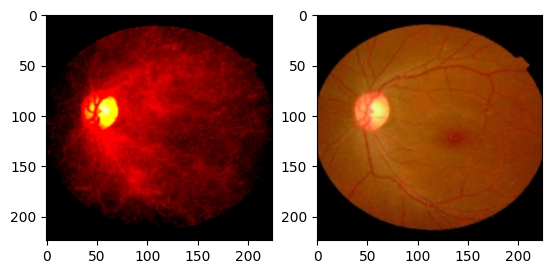

In [ ]:
idx = np.random.randint(0, len(train_ds))
img, label = train_ds[idx]
print(idx, label)
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))

# Convert back to original value
img_raw = img.numpy().transpose(1, 2, 0) # (3, 256, 256) -> (256, 256, 3)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_raw = std * img_raw + mean
img_raw = np.clip(img_raw, 0, 1)
print(img_raw.shape)
plt.subplot(1, 2, 2)
plt.imshow(img_raw)
plt.show()
# img, label = train_ds[0]
# print(img.shape, label)

# img = img.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
# plt.imshow(img)
# plt.show()

In [ ]:
img, label

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

#### [TODO] Model

In [ ]:
# 繼承nn.Module,初始__init__化定義有哪些層（參數輸入input channel數,output channel數）,forward函數定義從資料進來到出去的步驟。
# class ConvBN(nn.Module):
#     def __init__(self, cin, cout, kernel_size = 3):
#         super().__init__()
#         self.conv = nn.Conv2d(cin, cout, kernel_size, padding='same')
#         self.bn = nn.BatchNorm2d(num_features=cout)
#         self.act = nn.LeakyReLU()
#     def forward(self, x):
#         x = self.conv(x)
#         x = self.bn(x)
#         return self.act(x)

# class CNN(nn.Module):
#     def __init__(self, kernel_size=3):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             ConvBN(3, 16, kernel_size ),
#             ConvBN(16, 16, kernel_size),
#             nn.MaxPool2d(kernel_size=2),

#             ConvBN(16, 32, kernel_size),
#             ConvBN(32, 32, kernel_size),
#             nn.MaxPool2d(kernel_size=2),

#             ConvBN(32, 64,kernel_size),
#             ConvBN(64, 64,kernel_size),
#             nn.MaxPool2d(kernel_size=2),
#         )
#         self.flatten = nn.Flatten() # 輾平後特徵數量為通道＊長＊寬，其中長寬要計算卷幾過程中的改變
#         self.classifier = nn.Sequential(
#             nn.Dropout(0.3),
#             nn.Linear(64*28*28, 256),
#             nn.Dropout(0.3),
#             nn.LeakyReLU(),
#             nn.Linear(256, NUM_CLASS),
#         )
#         # 使用crossentropyloss作為損失函數時，函數損失不參考數值只看正確比率故在線性層不需使用softmax函數
#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.flatten(x)
#         x = self.classifier(x)
#         return x

In [ ]:
Freeze = False

In [ ]:
model = models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT)
print(model)
# 引用在參數中把使用imagenet預訓練的權重指定給weights
# 同時檢視模型中線性層的名稱（fc）

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 64.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
# 要替代現性層故要知道輸入（卷積層的輸出）features 數量
num_feature = model.fc.in_features

# 如果要凍結參數
if Freeze:
  for param in model.parameters():
    param.requires_grad = False
# self.classifier = nn.Sequential(
#             nn.Dropout(0.3),
#             nn.Linear(num_feature , 512),
#             nn.Dropout(0.3),
#             nn.LeakyReLU(),
#             nn.Linear(512, NUM_CLASS),
model.fc = nn.Linear(num_feature, NUM_CLASS)

In [ ]:
inputs = torch.randn(1, 3, 224, 224).to(device)
model = model.to(device)
outputs = model(inputs)
outputs.shape

torch.Size([1, 5])

In [ ]:
# from torchsummary import summary # model summary
# Model summary
# summary(model, (3, 224, 224))

#### [TODO] Training

In [ ]:
# 定義損失函數與激活函數
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                            lr=1e-4, weight_decay=1)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [ ]:
from tqdm.auto import tqdm
EPOCHS = 100

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
erly_stop = 5
best_loss = np.inf
counter = 0
best_model = model
# np.inf-無限大
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ', counter)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    if val_loss < best_loss:
      counter = 0
      best_loss = val_loss
      best_model = model
    elif counter < erly_stop:
      counter += 1
    else:
      print('early stop')
      break
model = best_model


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 1.4632, train_acc: 0.443     val_loss: 1.2732, val_acc: 0.564  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 1.2480, train_acc: 0.561     val_loss: 1.0675, val_acc: 0.618  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 1.1040, train_acc: 0.612     val_loss: 0.9680, val_acc: 0.650  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 1.0147, train_acc: 0.650     val_loss: 0.9015, val_acc: 0.700  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 0.9509, train_acc: 0.676     val_loss: 0.8686, val_acc: 0.714  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 0.9068, train_acc: 0.702     val_loss: 0.8356, val_acc: 0.725  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 0.8705, train_acc: 0.705     val_loss: 0.8093, val_acc: 0.732  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0007     train_loss: 0.8459, train_acc: 0.713     val_loss: 0.7876, val_acc: 0.727  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0008     train_loss: 0.8173, train_acc: 0.721     val_loss: 0.7747, val_acc: 0.752  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0009     train_loss: 0.7992, train_acc: 0.723     val_loss: 0.7640, val_acc: 0.734  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0010     train_loss: 0.7860, train_acc: 0.723     val_loss: 0.7442, val_acc: 0.743  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0011     train_loss: 0.7494, train_acc: 0.731     val_loss: 0.7206, val_acc: 0.748  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0012     train_loss: 0.7323, train_acc: 0.732     val_loss: 0.7119, val_acc: 0.745  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0013     train_loss: 0.7067, train_acc: 0.737     val_loss: 0.7021, val_acc: 0.750  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0014     train_loss: 0.7014, train_acc: 0.736     val_loss: 0.6890, val_acc: 0.745  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0015     train_loss: 0.6840, train_acc: 0.746     val_loss: 0.6937, val_acc: 0.750  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0016     train_loss: 0.6658, train_acc: 0.743     val_loss: 0.6951, val_acc: 0.755  1


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0017     train_loss: 0.6509, train_acc: 0.754     val_loss: 0.6841, val_acc: 0.752  2


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0018     train_loss: 0.6431, train_acc: 0.758     val_loss: 0.6671, val_acc: 0.761  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0019     train_loss: 0.6356, train_acc: 0.755     val_loss: 0.6659, val_acc: 0.766  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0020     train_loss: 0.6307, train_acc: 0.762     val_loss: 0.6860, val_acc: 0.761  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0021     train_loss: 0.6259, train_acc: 0.770     val_loss: 0.6725, val_acc: 0.759  1


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0022     train_loss: 0.5953, train_acc: 0.773     val_loss: 0.6717, val_acc: 0.764  2


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0023     train_loss: 0.6028, train_acc: 0.771     val_loss: 0.6560, val_acc: 0.775  3


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0024     train_loss: 0.5897, train_acc: 0.780     val_loss: 0.6903, val_acc: 0.768  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0025     train_loss: 0.5883, train_acc: 0.772     val_loss: 0.7154, val_acc: 0.761  1


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0026     train_loss: 0.5766, train_acc: 0.779     val_loss: 0.6573, val_acc: 0.784  2


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0027     train_loss: 0.5698, train_acc: 0.788     val_loss: 0.6786, val_acc: 0.761  3


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0028     train_loss: 0.5406, train_acc: 0.796     val_loss: 0.6358, val_acc: 0.791  4


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0029     train_loss: 0.5325, train_acc: 0.817     val_loss: 0.6620, val_acc: 0.782  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0030     train_loss: 0.5443, train_acc: 0.803     val_loss: 0.6482, val_acc: 0.775  1


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0031     train_loss: 0.5186, train_acc: 0.816     val_loss: 0.7072, val_acc: 0.766  2


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0032     train_loss: 0.5425, train_acc: 0.805     val_loss: 0.6661, val_acc: 0.786  3


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0033     train_loss: 0.5282, train_acc: 0.811     val_loss: 0.6766, val_acc: 0.777  4


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0034     train_loss: 0.5320, train_acc: 0.813     val_loss: 0.6187, val_acc: 0.802  5


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0035     train_loss: 0.5168, train_acc: 0.816     val_loss: 0.7042, val_acc: 0.736  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0036     train_loss: 0.5186, train_acc: 0.823     val_loss: 0.6151, val_acc: 0.800  1


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0037     train_loss: 0.5109, train_acc: 0.815     val_loss: 0.6434, val_acc: 0.784  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0038     train_loss: 0.5290, train_acc: 0.810     val_loss: 0.6307, val_acc: 0.807  1


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0039     train_loss: 0.4770, train_acc: 0.836     val_loss: 0.7218, val_acc: 0.770  2


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0040     train_loss: 0.5329, train_acc: 0.813     val_loss: 0.6008, val_acc: 0.786  3


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0041     train_loss: 0.5234, train_acc: 0.811     val_loss: 0.5924, val_acc: 0.809  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0042     train_loss: 0.5281, train_acc: 0.809     val_loss: 0.6149, val_acc: 0.795  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0043     train_loss: 0.5082, train_acc: 0.824     val_loss: 0.5313, val_acc: 0.805  1


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0044     train_loss: 0.5097, train_acc: 0.814     val_loss: 0.6308, val_acc: 0.786  0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0045     train_loss: 0.5004, train_acc: 0.817     val_loss: 0.5789, val_acc: 0.798  1


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0046     train_loss: 0.5131, train_acc: 0.820     val_loss: 0.6103, val_acc: 0.795  2


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0047     train_loss: 0.5160, train_acc: 0.824     val_loss: 449.6454, val_acc: 0.477  3


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0048     train_loss: 0.5032, train_acc: 0.825     val_loss: 0.6139, val_acc: 0.798  4


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH: 0049     train_loss: 0.5365, train_acc: 0.815     val_loss: 0.6316, val_acc: 0.775  5
early stop


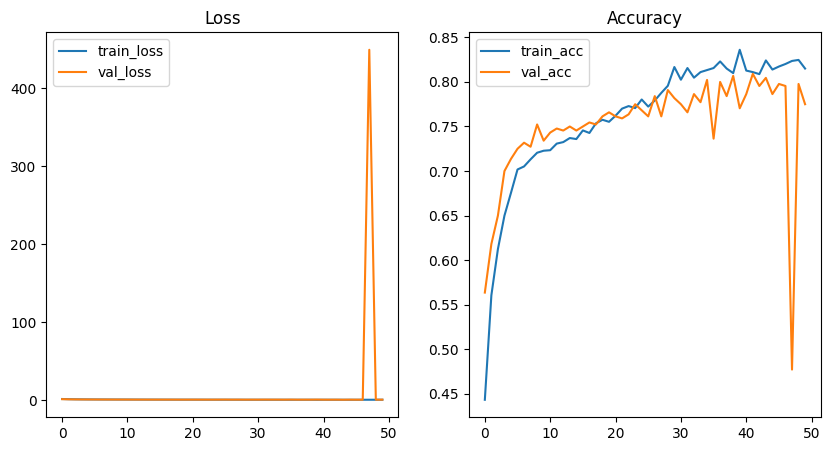

In [ ]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.legend(['train_loss', 'val_loss'])
# plot acc
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

In [ ]:
# Save model weights
PATH = './model_weights.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
model.load_state_dict(torch.load('model_weights.pth'))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

####Kaggle Submission

https://www.kaggle.com/competitions/diabetic-retinopathy-classification-3/overview

In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["id_code"]
        path = f"kaggle_retina/test/{filename}.png"
        img = Image.open(path)
        img = self.transform(img)
        return img

df = pd.read_csv('kaggle_retina/submission.csv')
test_ds = TestDataset(df, transform)
test_loader = torch.utils.data.DataLoader(test_ds, BATCH_SIZE)

In [ ]:
# Inference
y_pred = []
with torch.no_grad():
    for x in tqdm(test_loader):
        x = x.to(device)
        pred = model(x)
        y_pred.append(pred.argmax(dim=1))

y_pred = torch.cat(y_pred, dim=0).cpu().numpy()

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
df['diagnosis'] = y_pred
df.to_csv('submission.csv', index=None)